In [89]:
import torch
import numpy as np
from torch import Tensor
import pandas as pd

from matplotlib import rc_file
rc_file("../../matplotlibrc")

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

from labproject.metrics.MMD import *
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
from labproject.metrics.c2st import *

In [90]:
cxr1 = torch.load('../../data/cxr/encs_real.pt')
cxr2 = torch.load('../../data/cxr/encs_fake.pt')
ddm1 = torch.load('../../data/ddm/real_data.pt')
ddm2 = torch.load('../../data/ddm/generated_data.pt')

In [91]:
class Metric:
    def __init__(self, name: str, func: callable, **kwargs):
        self.name = name
        self.func = func
        self.kwargs = kwargs

    def __call__(self, x: Tensor, y: Tensor) -> Tensor:
        return self.func(x, y, **self.kwargs)
    

class DistComp:
    def __init__(self, dataset1: Tensor, dataset2: Tensor, metric: Metric, 
                 n_perms: int = 100, perm_size=1000, descr=""):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.metric = metric
        self.n_perms = n_perms
        self.perm_size = perm_size
        self.descr = descr

        columns = [metric.name]
        self.results_df = pd.DataFrame(np.nan, index=range(self.n_perms), columns=columns)

    def run_experiment(self):
        for i in range(self.n_perms):
            dataset2_perm = self.dataset2[torch.randperm(len(self.dataset2))[:self.perm_size]]
            dataset1_perm = self.dataset1[torch.randperm(len(self.dataset1))[:self.perm_size]]
            self.results_df.loc[i, self.metric.name] = tensor(self.metric(dataset1_perm, dataset2_perm)).numpy()
    
    def reformat_df(self, data):
        """
        reformat the results_df to work with seaborn plot expectations.
        """
        metric = [column_name for _, row in data.iterrows() for column_name, _ in row.items()]
        split_ind = [i for i, _ in data.iterrows() for _ in range(len(data.columns))]
        distance = [value for _, row in data.iterrows() for _, value in row.items()]

        return pd.DataFrame({"metric": metric, "distance": distance, "split_ind": split_ind})
        

In [92]:

metrics = [
    Metric('wasserstein', 
           sliced_wasserstein_distance),
    Metric('mmd-rbf', 
           mmd_rbf),
    Metric('c2st-knn', 
           c2st_knn,
           ),
]

datasets = [
    (ddm1, ddm1),
    (ddm1, ddm2),
    (ddm2, ddm2),
    (cxr1, cxr1),
    (cxr1, cxr2),
    (cxr2, cxr2),
]

descr_list = ['ddm - real vs real', 
              'ddm - real vs fake',
              'ddm - fake vs fake',
              'cxr - real vs real',
              'cxr - real vs fake',
              'cxr - fake vs fake']

experiments = []

for metric in metrics:
    for dataset, descr in zip(datasets, descr_list):
        experiments.append(
            DistComp(dataset[0], dataset[1], metric, n_perms=10, perm_size=100, descr=descr)
        )


for experiment in experiments:
    experiment.run_experiment()


C:\Users\zina\AppData\Local\Temp\ipykernel_15892\770344512.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.results_df.loc[i, self.metric.name] = tensor(self.metric(dataset1_perm, dataset2_perm)).numpy()
C:\Users\zina\AppData\Local\Temp\ipykernel_15892\770344512.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.results_df.loc[i, self.metric.name] = tensor(self.metric(dataset1_perm, dataset2_perm)).numpy()
C:\Users\zina\AppData\Local\Temp\ipykernel_15892\770344512.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.r

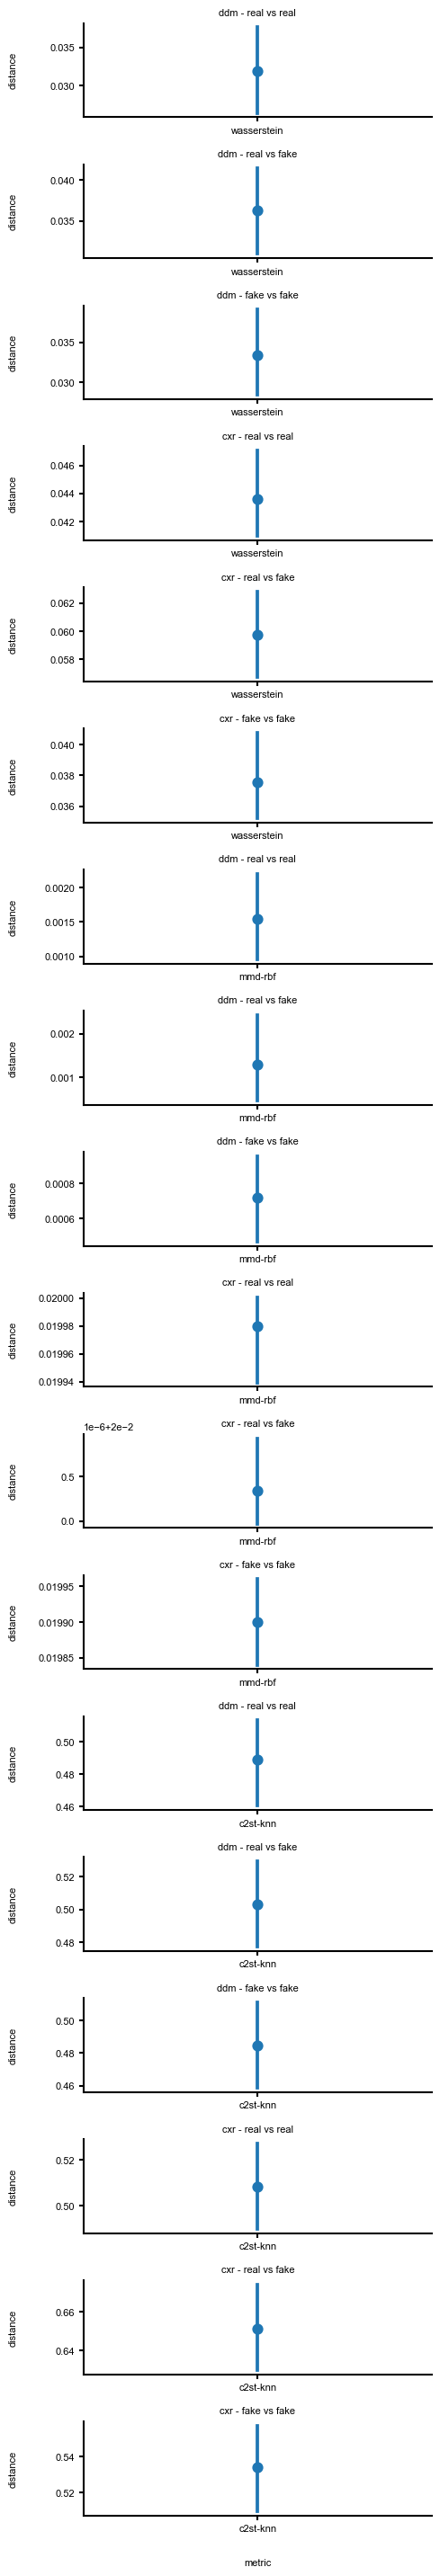

In [93]:
nm_plots = len(experiments)

fig = plt.figure(figsize=(5,2*nm_plots))
gs = gridspec.GridSpec(nm_plots,1, figure=fig, hspace=0.5)

for i, experiment in enumerate(experiments): 

    title = experiment.descr
    data = experiment.reformat_df(experiment.results_df)
    
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[i])

    ax = fig.add_subplot(gs00[:,:])

    sns.pointplot(data=data, x = "metric", y="distance", linestyles="none")
    
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.text(-0.2, 0.5, 'distance', transform=ax.transAxes, rotation='vertical',
            ha='center', va='center')

ax.text(0.5, -.5, 'metric', transform=ax.transAxes, rotation='horizontal',
            ha='center', va='center')

plt.show()
